In [61]:
import csv
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests

# Parameters

In [62]:
api = True
file = '/Users/adel.schmucklermann/Downloads/51888_simulated_hsqc_all.csv'

x_shift = []
y_shift = []
aa = []

# DB API

In [118]:
ID = '34172' #34172 #34243 #18851 #18820 #50743 #50914 #50940 #34648

if api:
    
    #{AA_index = [AA_name, (H,H_value), (N,N_value)]}
    aa_shift_dict = {}
    
    #requests.get("http://api.bmrb.io/v2/status", headers={"Application":"My Application"})
    x = requests.get("http://api.bmrb.io/current/entry/"+ID)
    entry = x.json() 
    
    #atom_chem_shift = entry[ID]['saveframes'][12]#['loops'][2]#['data']
    entry_list = entry[ID]['saveframes']
    
    counter = 0
    for dic in entry_list:
        if dic["category"] == 'assigned_chemical_shifts':
            break
        counter = counter+1
        
    sub = entry_list[counter]['loops']
    
    #print(sub)
    
    
    counter = 0
    for dic in sub:
        if dic['category'] == '_Atom_chem_shift':
            break
        counter = counter+1
        
    #print(sub[counter])    
    #print('Category: '+ atom_chem_shift['category'])
    #print(atom_chem_shift['tags'])
    #atom_chem_shift['data']
    
    #print(sub[counter]['tags'])
    
    tags = sub[counter]['tags']

    cii = int(tags.index('Comp_index_ID'))
    ci = int(tags.index('Comp_ID'))
    ai = int(tags.index('Atom_ID'))
    v = int(tags.index('Val'))
        
    #print(v)
    
    data = sub[counter]['data']
    # print(data)
    #save x/y_shift of H/N atom of AA in dictionary
    for i in data: 
        Comp_index_ID = i[cii]
        Comp_ID = i[ci]
        Atom_ID = i[ai]
        Val = i[v]
        
        if Atom_ID == 'H' or Atom_ID == 'N':
            #print(Comp_ID+": "+Val)
    
            
            if Comp_index_ID not in aa_shift_dict:
                aa_shift_dict[Comp_index_ID] = [Comp_ID, Atom_ID,float(Val)]
                #print(aa_shift_dict[Comp_index_ID])
            else:
                temp_list = aa_shift_dict[Comp_index_ID]
                temp_list.append(Atom_ID)
                temp_list.append(float(Val))
                aa_shift_dict[Comp_index_ID] = temp_list
                
    #print(aa_shift_dict)
    df = pd.DataFrame.from_dict(aa_shift_dict,orient="index")
    
    col1 = df[1].unique()
    col2 = df[3].unique()
    #print(col2)
    
    if len(col1) == 1 and len(col2)== 1:
        df = df.drop(df.columns[[1, 3]],axis = 1)
        df.columns = ['Residue', col1[0], col2[0]]
    else:
        df = df.drop(df[(df[1] == None) | (df[3] == None)].index)
        df = df.drop(df.columns[[1, 3]],axis = 1)
        df.columns = ['Residue', col1[0], col2[0]]

    #print(df)   
    print(df.sort_values(by=['Residue']))
    
    #print(df[df['Residue']=="GLN"])
    
    

   Residue      H        N
53     ALA  8.623  121.653
34     ALA  8.462  122.046
78     ALA  8.727  125.224
82     ALA  8.126  124.902
21     ALA  7.486  121.611
..     ...    ...      ...
41     VAL  7.360  112.803
9      VAL  7.415  119.862
46     VAL  7.193  119.485
79     VAL  8.276  118.082
50     VAL  8.684  120.436

[90 rows x 3 columns]


In [119]:
if not api:

    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            if row[0] != 'sequence':
                aa.append(row[1])
                x_shift.append(float(row[2]))
                y_shift.append(float(row[3]))
                
    df = pd.DataFrame(dict(Residue=aa, H=x_shift, N=y_shift))            
    print(df)

# Scatterplot of Simulated HSQC

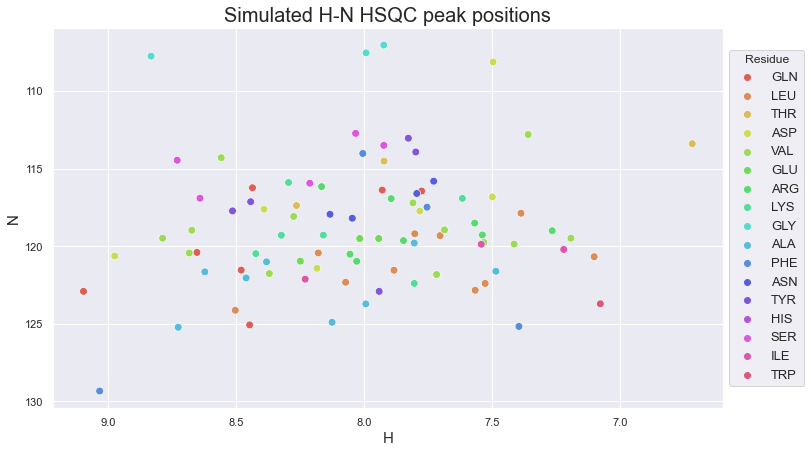

In [120]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 7)) 

sns.scatterplot(ax=ax, data=df,x='H', y='N', hue='Residue',palette='hls',s=60)

title = 'Simulated H-N HSQC peak positions'
plt.title(title,fontsize=20)
ax.set_xlabel("H",fontsize=15)
ax.set_ylabel("N",fontsize=15)
ax.legend(title='Residue',loc='center left',bbox_to_anchor=(1, 0.5),fontsize=13)

#inver x/y axis
ax.invert_xaxis()
ax.invert_yaxis()

plt.savefig('/Users/adel.schmucklermann/Downloads/self_bmr'+ID+'.png')
plt.show()

